# **Data Preparation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import pathlib
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import cv2
import skimage
from skimage.util import random_noise
import tensorflow as tf

from tqdm.notebook import tqdm
import random

In [ ]:
def get_images_paths(root_dir_ssid, root_dir_mi, root_dir_nind):
    # Getting SSID dataset images
    root = pathlib.Path(root_dir_ssid)
    img_paths = list(root.rglob("*.PNG*"))
    img_paths_lst = [str(path) for path in img_paths]

    gt_lst = []
    noisy_lst= []
    for p in img_paths_lst:
        img_type = p.split("/")[-1].split('_')[-3]
        if img_type=="NOISY":
            noisy_lst.append(p)
        elif img_type=="GT":
            gt_lst.append(p)

    # Getting mi dataset images
    root = pathlib.Path(root_dir_mi)
    img_paths = list(root.rglob("*.bmp*"))
    img_paths_lst = [str(path) for path in img_paths]

    for p in img_paths_lst:
        img_type = p.split("/")[-1].split('_')[-1]
        if "Noisy" in img_type:
            noisy_lst.append(p)
        elif "Reference" in img_type:
            gt_lst.append(p)
            gt_lst.append(p)


    # Getting NIND dataset images
    root = pathlib.Path(root_dir_nind)
    img_paths = list(root.rglob("*.png*"))
    img_paths.extend(list(root.rglob("*.jpg*")))
    img_paths_lst = [str(path) for path in img_paths]

    for p in img_paths_lst:
        img_type = p.split("/")[-1].split("_")[-1]
        if "H" in img_type:
            noisy_lst.append(p)
        else:
            gt_lst.append(p)

    noisy_array = np.asarray(noisy_lst)
    gt_array = np.asarray(gt_lst)
    return noisy_array, gt_array

In [ ]:
from sklearn.model_selection import train_test_split

noisy_array_paths, gt_array_paths = get_images_paths("/content/drive/MyDrive/dataset_6GB/SIDD_Small_sRGB_Only", "Mi3_Aligned", "NIND")

noisy_train_paths, noisy_test_paths, gt_train_paths, gt_test_paths = train_test_split(noisy_array_paths, gt_array_paths, test_size=0.20, random_state=42)

In [ ]:
print(noisy_train_paths.shape)
print(noisy_test_paths.shape)
print(gt_train_paths.shape)
print(gt_test_paths.shape)

(128,)
(32,)
(128,)
(32,)


In [ ]:
noisy_array_paths, gt_array_paths = get_images_paths("/content/drive/MyDrive/dataset_6GB/SIDD_Small_sRGB_Only", "Mi3_Aligned", "NIND")

train_indices = random.sample(range(len(noisy_array_paths)), int(len(noisy_array_paths)*0.8))
test_indices = set(range(len(noisy_array_paths))) - set(train_indices)

noisy_train_paths = noisy_array_paths[train_indices]
noisy_test_paths  = noisy_array_paths[list(test_indices)]

gt_train_paths = gt_array_paths[train_indices]
gt_test_paths  = gt_array_paths[list(test_indices)]

print(noisy_train_paths.shape)
print(noisy_test_paths.shape)
print(gt_train_paths.shape)
print(gt_test_paths.shape)

(128,)
(32,)
(128,)
(32,)


In [ ]:
# Get gt_images in memory
def get_images_in_mem(images_paths):
    images_lst = []
    for img_path in tqdm(images_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        images_lst.append(img)
    return np.array(images_lst)

In [ ]:
noisy_train_images = get_images_in_mem(noisy_train_paths)
noisy_test_images = get_images_in_mem(noisy_test_paths)

gt_train_images = get_images_in_mem(gt_train_paths)
gt_test_images = get_images_in_mem(gt_test_paths)

print(noisy_train_images.shape)
print(noisy_test_images.shape)

print(gt_train_images.shape)
print(gt_test_images.shape)

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

(128, 256, 256, 3)
(32, 256, 256, 3)
(128, 256, 256, 3)
(32, 256, 256, 3)


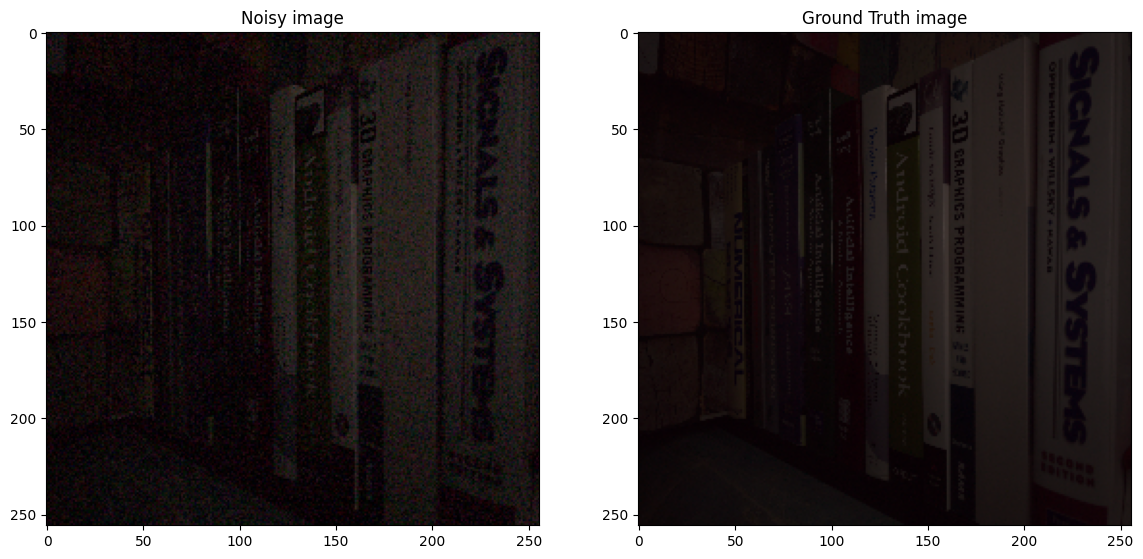

In [ ]:
f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(noisy_train_images[5])
axarr[0].set_title("Noisy image")
axarr[1].imshow(gt_train_images[5])
axarr[1].title.set_text("Ground Truth image")

In [ ]:
def _up_down_flip(image, label):
    image = tf.image.flip_up_down(image)
    label = tf.image.flip_up_down(label)
    return image, label

def _left_right_flip(image, label):
    image = tf.image.flip_left_right(image)
    label = tf.image.flip_left_right(label)
    return image, label

def _rotate(image, label):
    random_angle = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, random_angle)
    label = tf.image.rot90(label, random_angle)
    return image, label

def _hue(image, label):
    rand_value = random.uniform(-1,1)
    image = tf.image.adjust_hue(image, rand_value)
    label = tf.image.adjust_hue(label, rand_value)
    return image, label

def _brightness(image, label):
    rand_value = random.uniform(-0.08,0.25)
    image = tf.image.adjust_brightness(image, rand_value)
    label = tf.image.adjust_brightness(label, rand_value)
    return image, label

def _saturation(image, label):
    rand_value = random.uniform(1, 5)
    image = tf.image.adjust_saturation(image, rand_value)
    label = tf.image.adjust_saturation(label, rand_value)
    return image, label

def _contrast(image, label):
    rand_value = random.uniform(1, 3)
    image = tf.image.adjust_contrast(image, rand_value)
    label = tf.image.adjust_contrast(label, rand_value)
    return image, label

def tf_data_generator(X, y, batch_size=32, augmentations=None):
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) # This is the main step for data generation
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)

    if augmentations:
        for f in augmentations:
            if np.random.uniform(0,1)<0.5:
                dataset = dataset.map(f, num_parallel_calls=2)

    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

BATCH_SIZE=4
# augmentation_lst = [_up_down_flip, _left_right_flip, _rotate]
augmentation_lst = [_left_right_flip, _up_down_flip, _rotate, _hue, _brightness, _saturation, _contrast]
image_generator_train = tf_data_generator(X=noisy_train_images, y=gt_train_images, batch_size=BATCH_SIZE, augmentations=augmentation_lst)
image_generator_test = tf_data_generator(X=noisy_test_images, y=gt_test_images, batch_size=BATCH_SIZE)

In [ ]:
image_generator_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(4, 256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(4, 256, 256, 3), dtype=tf.uint8, name=None))>

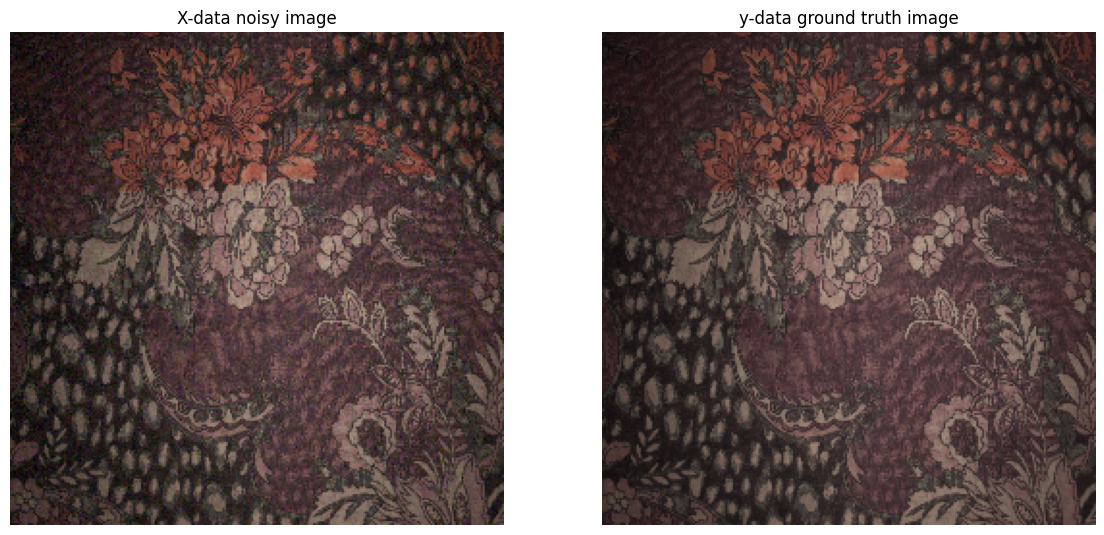

In [ ]:
# SANITY CHECK of the Dataset generator
for noisy, gt in image_generator_train.take(1):  # only take first element of dataset
    numpy_images = noisy.numpy()
    numpy_labels = gt.numpy()

f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(numpy_images[1])
axarr[0].set_title("X-data noisy image")
axarr[0].set_axis_off()

axarr[1].imshow(numpy_labels[1])
axarr[1].set_title("y-data ground truth image")
axarr[1].set_axis_off()

In [ ]:
print("Number of Training Set Images:", noisy_train_images.shape[0])
print("Number of Testing Set Images:", noisy_test_images.shape[0])

Number of Training Set Images: 128
Number of Testing Set Images: 32


In [ ]:
print("Number of Training Set Images (including augmentations):", noisy_train_images.shape[0] * (1 + len(augmentation_lst)))
print("Number of Testing Set Images (including augmentations):", noisy_test_images.shape[0] * (1 + len(augmentation_lst)))

Number of Training Set Images (including augmentations): 1024
Number of Testing Set Images (including augmentations): 256


# **MWCNN**

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,\
                                    GlobalAveragePooling2D, AveragePooling2D, MaxPool2D, UpSampling2D,\
                                    BatchNormalization, Activation, ReLU, Flatten, Dense, Input,\
                                    Add, Multiply, Concatenate, Softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax

tf.keras.backend.set_image_data_format('channels_last')
import keras.backend as K

In [ ]:
class Conv_block(tf.keras.layers.Layer):
    def  __init__(self, num_filters=200, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.num_filters=num_filters
        self.kernel_size=kernel_size
        self.conv_1 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_2 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_3 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_4 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')

        self.bn_1 = BatchNormalization()
        self.bn_2 = BatchNormalization()
        self.bn_3 = BatchNormalization()
        self.bn_4 = BatchNormalization()

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_filters': self.num_filters,
            'kernel_size':self.kernel_size
        })
        return config

    def call(self, X):
        X = self.conv_1(X)
        # X = self.bn_1(X)
        X = ReLU()(X)
        X = self.conv_2(X)
        # X = self.bn_2(X)
        X = ReLU()(X)
        X = self.conv_3(X)
        # X = self.bn_3(X)
        X = ReLU()(X)
        # X = self.conv_4(X)
        # # X = self.bn_4(X)
        # X = ReLU()(X)

        return X

In [ ]:
class DWT_downsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        x1 = x[:, 0::2, 0::2, :] #x(2i−1, 2j−1)
        x2 = x[:, 1::2, 0::2, :] #x(2i, 2j-1)
        x3 = x[:, 0::2, 1::2, :] #x(2i−1, 2j)
        x4 = x[:, 1::2, 1::2, :] #x(2i, 2j)

        x_LL = x1 + x2 + x3 + x4
        x_LH = -x1 - x3 + x2 + x4
        x_HL = -x1 + x3 - x2 + x4
        x_HH = x1 - x3 - x2 + x4

        return Concatenate(axis=-1)([x_LL, x_LH, x_HL, x_HH])

In [ ]:
class IWT_upsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):

        x_LL = x[:, :, :, 0:x.shape[3]//4]
        x_LH = x[:, :, :, x.shape[3]//4:x.shape[3]//4*2]
        x_HL = x[:, :, :, x.shape[3]//4*2:x.shape[3]//4*3]
        x_HH = x[:, :, :, x.shape[3]//4*3:]

        x1 = (x_LL - x_LH - x_HL + x_HH)/4
        x2 = (x_LL - x_LH + x_HL - x_HH)/4
        x3 = (x_LL + x_LH - x_HL - x_HH)/4
        x4 = (x_LL + x_LH + x_HL + x_HH)/4

        y1 = K.stack([x1,x3], axis=2)
        y2 = K.stack([x2,x4], axis=2)
        shape = K.shape(x)
        return K.reshape(K.concatenate([y1,y2], axis=-1), K.stack([shape[0], shape[1]*2, shape[2]*2, shape[3]//4]))

In [ ]:
# def create_model():
#     tf.keras.backend.clear_session()

#     input = Input(shape=(256,256,3))

#     cb_1 = Conv_block(num_filters=64)(input)
#     # print("cb 1=",cb_1.shape)
#     dwt_1 = DWT_downsampling()(cb_1)
#     # print("dwt 1=",dwt_1.shape)

#     cb_2 = Conv_block(num_filters=128)(dwt_1)
#     # print("cb 2=",cb_2.shape)
#     dwt_2 = DWT_downsampling()(cb_2)
#     # print("dwt 2=",dwt_2.shape)

#     cb_3 = Conv_block(num_filters=256)(dwt_2)
#     cb_4 = Conv_block(num_filters=256)(cb_3)
#     cb_4 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(cb_4)

#     iwt_1 = IWT_upsampling()(cb_4)
#     cb_5 = Conv_block(num_filters=128)(Add()([iwt_1, cb_2]))
#     cb_5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(cb_5)

#     iwt_2 = IWT_upsampling()(cb_5)
#     cb_6 = Conv_block(num_filters=64)(Add()([iwt_2, cb_1]))
#     cb_6 = Conv2D(filters=3, kernel_size=(1, 1), padding="same")(cb_6)

#     out = cb_6

#     return Model(inputs=[input], outputs=[out])

In [ ]:
def create_model():
    tf.keras.backend.clear_session()

    input = Input(shape=(256,256,3))

    cb_1 = Conv_block(num_filters=64)(input)
    dwt_1 = DWT_downsampling()(cb_1)

    cb_2 = Conv_block(num_filters=128)(dwt_1)
    dwt_2 = DWT_downsampling()(cb_2)

    cb_3 = Conv_block(num_filters=256)(dwt_2)
    dwt_3 = DWT_downsampling()(cb_3)

    cb_4 = Conv_block(num_filters=512)(dwt_3)
    dwt_4 = DWT_downsampling()(cb_4)

    cb_5 = Conv_block(num_filters=512)(dwt_4)
    cb_5 = BatchNormalization()(cb_5)
    cb_5 = Conv_block(num_filters=512)(cb_5)
    cb_5 = Conv2D(filters=2048, kernel_size=3, strides=1, padding='same')(cb_5)

    up = IWT_upsampling()(cb_5)
    up = Conv_block(num_filters=512)(Add()([up, cb_4]))
    up = Conv2D(filters=1024, kernel_size=3, strides=1, padding='same')(up)

    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=256)(Add()([up, cb_3]))
    up = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(up)

    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=128)(Add()([up, cb_2]))
    up = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(up)

    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=64)(Add()([up, cb_1]))
    up = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(up)

    out = Conv2D(filters=3, kernel_size=(1, 1), padding="same")(up)

    return Model(inputs=[input], outputs=[out])

model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv_block (Conv_block)     (None, 256, 256, 64)         75648     ['input_1[0][0]']             
                                                                                                  
 dwt_downsampling (DWT_down  (None, 128, 128, 256)        0         ['conv_block[0][0]']          
 sampling)                                                                                        
                                                                                                  
 conv_block_1 (Conv_block)   (None, 128, 128, 128)        590208    ['dwt_downsampling[0][0]']

# **Training**

In [ ]:
steps_per_epoch_train = len(noisy_train_images)
steps_per_epoch_validation = len(noisy_test_images)

In [ ]:
callbacks_lst = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.0000009, min_delta=0.0001, factor=0.70, patience=3, verbose=1, mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.0001, patience=10)
]

In [ ]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.0009))
model.fit(image_generator_train,
          validation_data=image_generator_test,
                        steps_per_epoch=steps_per_epoch_train,
                        validation_steps=steps_per_epoch_validation,
                        epochs=120,
                        verbose=1,
                        callbacks=callbacks_lst)

Epoch 1/120
128/128 [==============================] - 89s 444ms/step - loss: 42293.1875 - val_loss: 424.6287 - lr: 9.0000e-04
Epoch 2/120
128/128 [==============================] - 57s 448ms/step - loss: 318.2550 - val_loss: 344.2399 - lr: 9.0000e-04
Epoch 3/120
128/128 [==============================] - 59s 463ms/step - loss: 196.8433 - val_loss: 161.8074 - lr: 9.0000e-04
Epoch 4/120
128/128 [==============================] - 60s 468ms/step - loss: 117.5896 - val_loss: 127.6745 - lr: 9.0000e-04
Epoch 5/120
128/128 [==============================] - 60s 471ms/step - loss: 99.2670 - val_loss: 126.0695 - lr: 9.0000e-04
Epoch 6/120
128/128 [==============================] - 61s 476ms/step - loss: 80.5370 - val_loss: 80.8664 - lr: 9.0000e-04
Epoch 7/120
128/128 [==============================] - 60s 471ms/step - loss: 91.3091 - val_loss: 96.9770 - lr: 9.0000e-04
Epoch 8/120
128/128 [==============================] - 60s 470ms/step - loss: 61.9009 - val_loss: 68.4557 - lr: 9.0000e-04
Epoch

In [ ]:
models_path = "/content/drive/MyDrive/Colab Notebooks/DenoisingModels/CNN/"
model.save(models_path+"CNN_blindnoise_256x256.h5")

In [ ]:
best_models_path = "/content/drive/MyDrive/EDI/"
model = tf.keras.models.load_model(best_models_path+'CNN_blindnoise_256x256 (1).h5', custom_objects={'DWT_downsampling':DWT_downsampling,
                                                                                                        'IWT_upsampling':IWT_upsampling,
                                                                                                        'Conv_block':Conv_block})

# **Inference**

gt_images are in range of 0-255 (int);<br>
noisy_images are in range of 0-255 (int);<br>
predicted_images are in range 0-255 (float);

In [ ]:
# Inference
def inference_single_image(model, noisy_image):
    input_image = np.expand_dims(noisy_image, axis=0)
    predicted_image = model.predict(input_image)

    return predicted_image[0]

def inference_batch_images(model, noisy_images):
    predicted_image = model.predict(noisy_images)
    return predicted_image

In [ ]:
def visualize_predictions(model, X_test, y_test, n):
    random_numbers = random.choices(range(X_test.shape[0]), k=n)    # Get n random indices
    for i in random_numbers:
        noisy_image = X_test[i]
        gt_image = y_test[i]
        predicted_image = inference_single_image(model, X_test[i])
        predicted_image/=255

        f, axarr = plt.subplots(1,3, figsize=(21,21))
        axarr[0].imshow(noisy_image)
        axarr[0].set_title("Noisy image")
        axarr[0].set_axis_off()
        axarr[1].imshow(gt_image)
        axarr[1].set_title("Ground truth image")
        axarr[1].set_axis_off()
        axarr[2].imshow(predicted_image)
        axarr[2].set_title("Predicted image")
        axarr[2].set_axis_off()

In [ ]:
visualize_predictions(model, noisy_test_images, gt_test_images, 10)

NameError: ignored

1/1 [==============================] - 4s 4s/step


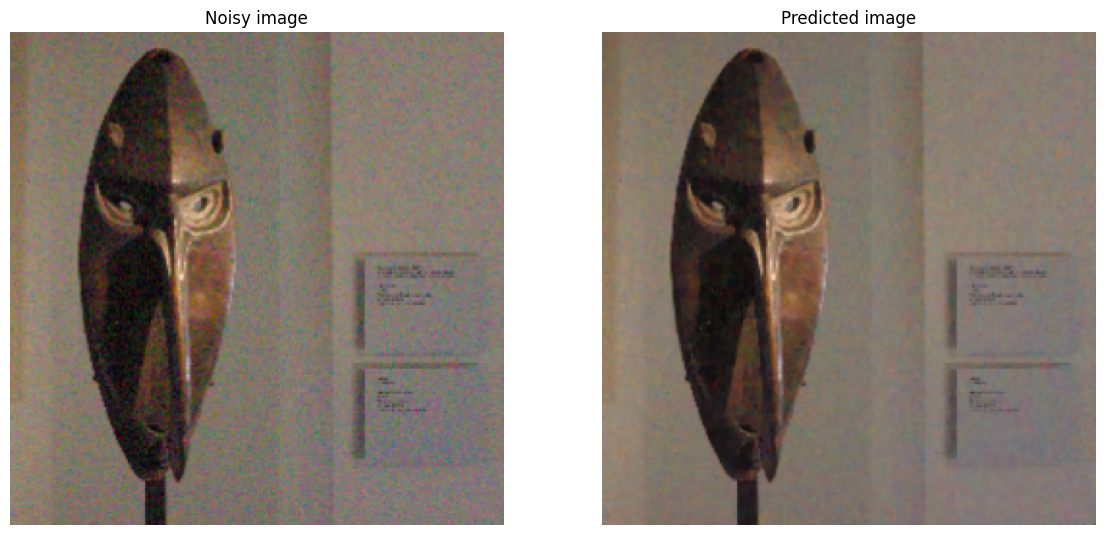

In [ ]:
# Test image prediction


img_path = "/content/Capture.PNG"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))

predicted_image = inference_single_image(model, img)
predicted_image/=255

f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(img)
axarr[0].title.set_text("Noisy image")
axarr[0].set_axis_off()

axarr[1].imshow(predicted_image)
axarr[1].title.set_text("Predicted image")
axarr[1].set_axis_off()

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images.shape[0]
psnr_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

1/1 [==============================] - 17s 17s/step
Original average gt-noisy PSNR -> 29.361616364780385
Predicted average gt-predicted PSNR -> 35.42046361667315


In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images.shape[0]
ssim_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

1/1 [==============================] - 0s 27ms/step
Original average gt-noisy SSIM -> 0.6685963124743535
Predicted average gt-predicted SSIM -> 0.8650081460501352


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

predicted_images = inference_batch_images(model, noisy_test_images)
mse_original_mean = 0
mse_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    # Flatten the images to 1D arrays
    gt_img_flat = gt_img.ravel()
    noisy_img_flat = noisy_img.ravel()
    predicted_img_flat = predicted_img.ravel()

    mse_original_mean += mean_squared_error(gt_img_flat, noisy_img_flat)
    mse_prediction_mean += mean_squared_error(gt_img_flat, predicted_img_flat)

mse_original_mean /= len(gt_test_images)
mse_prediction_mean /= len(gt_test_images)
print("Original average gt-noisy MSE ->", mse_original_mean)
print("Predicted average gt-predicted MSE ->", mse_prediction_mean)


1/1 [==============================] - 0s 32ms/step
Original average gt-noisy MSE -> 46.45865122477215
Predicted average gt-predicted MSE -> 22.411387994885445


##PREDICTIONS


In [ ]:
# !pip install gradio


In [ ]:
# import gradio


In [ ]:
# def predict(img):
#   # img_3d=img.reshape(-1,180,180,3)
#   # prediction=model.predict(img_3d)[0]
#   # img_path = "/content/drive/MyDrive/Colab Notebooks/astronaut.png"

#   # img = cv2.imread(img_path)
#   # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#   # # img = cv2.resize(img, (256, 256))

#   predicted_image = inference_single_image(model, img)
#   predicted_image/=255
#   return predicted_image


In [ ]:
# image = gr.inputs.Image(shape=(256,256))
# label=gr.outputs.Label()

# gr.Interface(fn=predict,inputs=image,output=label,capture_session=True).launch(debug='True')

# ***WEBPAGE***


In [ ]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.8/731.8 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-7.0.1-py3-none-any.whl size=21122 sha256=a2a7143f2f94bdf2b70122ad219d5c0238ae63aede5984f42879ae34001f5328
  Stored in directory: /root/.cache/pip/wheels/3b/32/0e/27789b6fde02bf2b320d6f1a0fd9e1354b257c5f75eefc29bc
Successfully built pyngrok


In [ ]:
%%writefile app1.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.losses import MeanSquaredError

class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, num_filters=200, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.conv_1 = tf.keras.layers.Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_2 = tf.keras.layers.Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_3 = tf.keras.layers.Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_4 = tf.keras.layers.Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')

        self.bn_1 = tf.keras.layers.BatchNormalization()
        self.bn_2 = tf.keras.layers.BatchNormalization()
        self.bn_3 = tf.keras.layers.BatchNormalization()
        self.bn_4 = tf.keras.layers.BatchNormalization()

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_filters': self.num_filters,
            'kernel_size': self.kernel_size
        })
        return config

    def call(self, X):
        X = self.conv_1(X)
        X = tf.keras.activations.relu(X)
        X = self.conv_2(X)
        X = tf.keras.activations.relu(X)
        X = self.conv_3(X)
        X = tf.keras.activations.relu(X)

        return X

class DWT_downsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        x1 = x[:, 0::2, 0::2, :]
        x2 = x[:, 1::2, 0::2, :]
        x3 = x[:, 0::2, 1::2, :]
        x4 = x[:, 1::2, 1::2, :]

        x_LL = x1 + x2 + x3 + x4
        x_LH = -x1 - x3 + x2 + x4
        x_HL = -x1 + x3 - x2 + x4
        x_HH = x1 - x3 - x2 + x4

        return tf.keras.layers.Concatenate(axis=-1)([x_LL, x_LH, x_HL, x_HH])

class IWT_upsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        x_LL = x[:, :, :, 0:x.shape[3]//4]
        x_LH = x[:, :, :, x.shape[3]//4:x.shape[3]//4*2]
        x_HL = x[:, :, :, x.shape[3]//4*2:x.shape[3]//4*3]
        x_HH = x[:, :, :, x.shape[3]//4*3:]

        x1 = (x_LL - x_LH - x_HL + x_HH) / 4
        x2 = (x_LL - x_LH + x_HL - x_HH) / 4
        x3 = (x_LL + x_LH - x_HL - x_HH) / 4
        x4 = (x_LL + x_LH + x_HL + x_HH) / 4

        y1 = tf.keras.backend.stack([x1, x3], axis=2)
        y2 = tf.keras.backend.stack([x2, x4], axis=2)
        shape = tf.keras.backend.shape(x)
        return tf.keras.backend.reshape(tf.keras.backend.concatenate([y1, y2], axis=-1),
                                       tf.keras.backend.stack([shape[0], shape[1]*2, shape[2]*2, shape[3]//4]))

# Load the pre-trained model with custom layers
with tf.keras.utils.custom_object_scope({
    'ConvBlock': ConvBlock,
    'DWT_downsampling': DWT_downsampling,
    'IWT_upsampling': IWT_upsampling
}):
    # Load the pre-trained model
     model = tf.keras.models.load_model(r'/content/drive/MyDrive/EDI/CNN_blindnoise_256x256 (1).h5', custom_objects={
        'Conv_block': ConvBlock,
        'DWT_downsampling': DWT_downsampling,
        'IWT_upsampling': IWT_upsampling
        })

# Inference function
def inference_single_image(model, noisy_image):
    # Keep only the first three channels if there are four channels
    noisy_image = noisy_image[:, :, :3]

    # Resize the input image to the expected shape (256, 256)
    noisy_image = tf.image.resize(noisy_image, (256, 256))

    # Preprocess the input image if needed (adjust this based on your training preprocessing)
    # For example, if the model was trained with normalization, uncomment the line below:
    # noisy_image = preprocess_input(noisy_image)

    input_image = np.expand_dims(noisy_image, axis=0)
    predicted_image = model.predict(input_image)

    # Clip values to be within [0.0, 1.0]
    predicted_image = np.clip(predicted_image[0] / 255, 0.0, 1.0)

    return predicted_image



# Streamlit app
def main():
    st.title("Image Denoising Web App")
    st.sidebar.title("Options")

    # File uploader
    uploaded_file = st.sidebar.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

    if uploaded_file is not None:
        # Display the uploaded image
        st.image(uploaded_file, caption="Input Image", use_column_width=True)

        # Preprocess and denoise the image
        img = Image.open(uploaded_file)
        img = np.array(img)  # No resizing
        predicted_image = inference_single_image(model, img)

        # Display the denoised image without changing its dimensions
        st.subheader("Denoised Image")
        st.image(predicted_image, caption="Denoised Image", use_column_width=True, channels="RGB", output_format="JPEG")

if __name__ == "__main__":
    main()

Overwriting app1.py


In [ ]:
import requests

def get_public_ip():
    try:
        response = requests.get('https://api64.ipify.org?format=json')
        ip_data = response.json()
        return ip_data['ip']
    except Exception as e:
        return str(e)

public_ip = get_public_ip()
print(f"Your public IP address is: {public_ip}")

Your public IP address is: 34.125.159.58


In [ ]:
!streamlit run app1.py & npx localtunnel --port 8501

[##................] - fetchMetadata: sill resolveWithNewModule yargs-parser@20

npx: installed 22 in 8.224s

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.159.58:8501

your url is: https://major-mangos-greet.loca.lt
2023-11-24 14:39:15.988450: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-24 14:39:15.988502: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-24 14:39:15.988539: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-24 14:39:16.961594: W tensorflow/compiler/tf2tensorrt/util